<div align="center">
  <img width="900" src="https://i.postimg.cc/wTj9BVP0/Yassine-Crypto.png">
</div>

**ta** is a Python package for performing **technical** **analysis** on financial data.

In [1]:
%%capture
! pip install ta

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import boxcox, yeojohnson
from scipy.stats import shapiro,kstest
from scipy.stats import pearsonr, spearmanr

import ipywidgets as widgets
from IPython.display import HTML, display
from ipywidgets import interactive
import plotly.graph_objs as go
import plotly.express as px
from ipywidgets import interact
from tabulate import tabulate

from ta.trend import SMAIndicator, EMAIndicator
from ta.volatility import AverageTrueRange
from ta.momentum import RSIIndicator
from ta.utils import dropna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [3]:
close_df = pd.read_csv('/kaggle/input/crypto/close.csv')
high_df = pd.read_csv('/kaggle/input/crypto/high.csv')
low_df= pd.read_csv('/kaggle/input/crypto/low.csv')
open_df = pd.read_csv('/kaggle/input/crypto/open.csv')
reddit_df = pd.read_csv('/kaggle/input/crypto/reddit_cc.csv')
volume_df = pd.read_csv('/kaggle/input/crypto/volume.csv')

In [101]:
#close_df.head().style.applymap(lambda x: "background-color: #0e1c32")

<div style="text-align: center;">
    <a style="font-family: Pluma; font-size: 50px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: white; background-color: #0e1c32;">Missing values</a>
</div>


The function 'rename_list' renames a specific column to 'timestamp' in each DataFrame and returns the modified list of DataFrames

In [5]:
def rename_list(dfs):
    modified_df = []
    for df in dfs:
        if 'Unnamed: 0' in df.columns:
            df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)
        modified_df.append(df)

    return modified_df

In [6]:
def time_converter(dataframes):
    for df in dataframes:
        if 'timestamp' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
            df['timestamp'] = pd.to_datetime(df['timestamp'])
    return dataframes

In [7]:
df_list = [close_df, high_df, low_df, open_df, volume_df, reddit_df]
df_list = rename_list(df_list)
df_list = time_converter(df_list)

In [8]:
def nas(df_list):
    for df in df_list:
        if not isinstance(df, pd.DataFrame):
            print("Invalid input.")
            return
        output_data = []
        headers = ['Column', 'Missing Values']
        for col in df.columns:
            count = df[col].isna().sum()
            if count > 0:
                output_data.append([col, count])
        if output_data:
            print(tabulate(output_data, headers=headers, tablefmt='pretty'))
        else:
            print("No missing values found.")
        print("\n")  

In [9]:
nas(df_list)

+-------------+----------------+
|   Column    | Missing Values |
+-------------+----------------+
| 1000XECUSDT |      2596      |
|   ANTUSDT   |      5021      |
|  ARPAUSDT   |      3364      |
|   ARUSDT    |      2860      |
|   ATAUSDT   |      2188      |
|  AUDIOUSDT  |      1900      |
| BTCDOMUSDT  |      484       |
|   C98USDT   |      2020      |
|  CELOUSDT   |      2836      |
|  CTSIUSDT   |      3532      |
|  DUSKUSDT   |      5284      |
|  DYDXUSDT   |      2428      |
|   ENSUSDT   |      4372      |
|  GALAUSDT   |      2620      |
|   GTCUSDT   |      244       |
|   ICPUSDT   |     10992      |
|  IOTXUSDT   |      1732      |
|  KLAYUSDT   |      3196      |
|   LPTUSDT   |      3916      |
|  MASKUSDT   |      2092      |
| PEOPLEUSDT  |      4949      |
|   RAYUSDT   |      1924      |
|  ROSEUSDT   |      5116      |
+-------------+----------------+


+-------------+----------------+
|   Column    | Missing Values |
+-------------+----------------+
| 1000XE

In [10]:
def plot_missing_values_over_time(df):
    
    timestamp_column = df.columns[0]
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df['timestamp'],
        y=df.isna().sum(axis=1),
        mode='lines+markers',
        line=dict(color='#51a4e7'), 
        marker=dict(color='#51a4e7'),  
        name='Missing Values'
    ))

    # Adding labels and title
    fig.update_layout(
        title='Missing Values Over Time ',
        xaxis_title='Timestamp',
        yaxis_title='Scaled Missing Value Counts ',
        xaxis=dict(tickangle=45),
        template='plotly_dark'  
    )

    # Show the plot
    fig.show()


In [11]:
plot_missing_values_over_time(close_df)

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            font-family: Belleza, Binate;
            background-color: #173765;
            margin: 0;
            padding: 0;
        }
        .container {
            max-width: 800px;
            margin: 20px auto;
            background-color: #787ff6;
            padding: 20px;
            border-radius: 10px;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
        }
        h1 {
            color: #333;
            text-align: center;
        }
        table {
            width: 100%;
            border-collapse: collapse;
            border-radius: 10px;
            overflow: hidden;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
            margin-top: 20px;
        }
        th, td {
            padding: 12px 15px;
            text-align: left;
            border-bottom: 1px solid #ddd;
        }
        th {
            background-color: #173765;
            color: #fff;
        }
        tr:nth-child(even) {
            background-color: #173765;
        }
    </style>
</head>
<body>

<div class="container">
    <h1>Cryptocurrency Launch Dates</h1>
    <table>
        <tr>
            <th>Cryptocurrency</th>
            <th>Launch Date</th>
        </tr>
        <tr>
            <td>XEC (eCash)</td>
            <td>July 1, 2021</td>
        </tr>
        <tr>
            <td>ANT (Aragon)</td>
            <td>May 17, 2021</td>
        </tr>
        <tr>
            <td>ARPA (ARPA Chain)</td>
            <td>April 2021</td>
        </tr>
        <tr>
            <td>AR (Arweave)</td>
            <td>June 2021</td>
        </tr>
        <tr>
            <td>ATA (Automata)</td>
            <td>June 2, 2021</td>
        </tr>
        <tr>
            <td>AUDIO (Audius)</td>
            <td>October 2020</td>
        </tr>
        <tr>
            <td>BTCDOM</td>
            <td>Not applicable</td>
        </tr>
        <tr>
            <td>C98 (Coin98)</td>
            <td>July 23, 2021</td>
        </tr>
        <tr>
            <td>CELO (Celo)</td>
            <td>April 22, 2021</td>
        </tr>
        <tr>
            <td>CTSI (Cartesi)</td>
            <td>April 2021</td>
        </tr>
        <tr>
            <td>DUSK (Dusk Network)</td>
            <td>December 2021</td>
        </tr>
        <tr>
            <td>DYDX (dYdX)</td>
            <td>February 2021</td>
        </tr>
        <tr>
            <td>ENS (Ethereum Name Service)</td>
            <td>May 4, 2021</td>
        </tr>
        <tr>
            <td>GALA (Gala Games)</td>
            <td>September 2020</td>
        </tr>
        <tr>
            <td>GTC (Gitcoin)</td>
            <td>May 25, 2021</td>
        </tr>
        <tr>
            <td>ICP (Internet Computer)</td>
            <td>May 10, 2021</td>
        </tr>
        <tr>
            <td>IOTX (IoTeX)</td>
            <td>February 2021</td>
        </tr>
        <tr>
            <td>KLAY (Klaytn)</td>
            <td>June 27, 2021</td>
        </tr>
        <tr>
            <td>LPT (Livepeer)</td>
            <td>April 2021</td>
        </tr>
        <tr>
            <td>MASK (Mask Network)</td>
            <td>February 24, 2021</td>
        </tr>
        <tr>
            <td>PEOPLE (ConstitutionDAO)</td>
            <td>November 2021</td>
        </tr>
        <tr>
            <td>RAY (Raydium)</td>
            <td>February 21, 2021</td>
        </tr>
        <tr>
            <td>ROSE (Oasis Network)</td>
            <td>November 2020</td>
        </tr>
    </table>
</div>

</body>
</html>


<div style="text-align: center;">
    <a style="font-family: Pluma; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: white; background-color: #0e1c32;">The missing values are due to the coin not being created yet.So I'm going to fill the NA's with '0'</a></div>
​
---

In [12]:
def missing_zero(dfs):
    for df in dfs:
        df.fillna(0, inplace=True)
    return 0

In [13]:
missing_zero(df_list)

0

In [14]:
nas(df_list)

No missing values found.


No missing values found.


No missing values found.


No missing values found.


No missing values found.


No missing values found.




<div style="text-align: center;">
    <a style="font-family: Pluma; font-size: 50px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: white; background-color: #0e1c32;">
First Visualization</a>
</div>


In [15]:
dfs = {'Close': close_df, 'High': high_df, 'Low': low_df, 'Open': open_df, 'Volume': volume_df}

In [16]:
df_options = list(dfs.keys())
coin_options = list(dfs['Close'].columns[1:])
date_options = list(dfs['Close']['timestamp'])

In [17]:
df_dropdown = widgets.Dropdown(options=df_options, value='Close', description='Dataframe:')
coin_dropdown = widgets.Dropdown(options=coin_options, value=coin_options[0], description='Coin:')

In [18]:
def update_histogram(selected_df, selected_coin):
    selected_data = dfs[selected_df]
    fig = px.histogram(selected_data, x='timestamp', y=selected_coin, title=f'Histogram for {selected_coin} over time')
    fig.show()

In [19]:
def update_oc_chart(selected_coin):
    trace_close = go.Scatter(
        x=close_df['timestamp'],
        y=close_df[selected_coin],
        mode="lines",
        name="Close",
        marker=dict(color='rgba(16, 112, 2, 0.8)'),
    )

    trace_open = go.Scatter(
        x=open_df['timestamp'],
        y=open_df[selected_coin],
        mode="lines+markers",
        name="Open",
        marker=dict(color='rgba(80, 26, 80, 0.8)'),
    )

    layout = dict(title=f'{selected_coin} - Close and Open Prices vs Date of Cryptocurrency',
                  xaxis=dict(title='Date', ticklen=5, zeroline=False),
                  yaxis=dict(title='Price'),
                  showlegend=True,
                  template='plotly_dark')

    fig = go.Figure(data=[trace_close, trace_open], layout=layout)
    fig.show()

In [20]:
coin_dropdown = widgets.Dropdown(options=coin_options, value=coin_options[0], description='Coin:')
interactive_plot = interactive(update_oc_chart, selected_coin=coin_dropdown)
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(Dropdown(description='Coin:', options=('1000SHIBUSDT', '1000XECUSDT', '1INCHUSDT', 'AAVE…

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; letter-spacing: 2.5px; color: white; background-color: #0e1c32;">All coins have similar charts.</a>
<br>
<a style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;"> > > I can analyse on a small number of coins </a>
---


<div style="text-align: center;">
    <a style="font-family: Pluma; font-size: 50px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: white; background-color: #0e1c32;">Coins selecting</a>
</div>

​
---


In [21]:
def top_10(df):
    col = df.columns[1:]
    sum_coin = df[col].sum()
    top_coins = sum_coin.nlargest(10)
    return top_coins

In [22]:
coins = top_10(volume_df)

In [23]:
coins

BTCUSDT         7.325441e+12
ETHUSDT         3.419471e+12
SOLUSDT         6.300845e+11
1000SHIBUSDT    4.135335e+11
XRPUSDT         3.817896e+11
ADAUSDT         3.777269e+11
DOGEUSDT        3.655085e+11
BNBUSDT         3.553390e+11
AVAXUSDT        2.844144e+11
FTMUSDT         2.827372e+11
dtype: float64

*     **BTCUSDT**: Bitcoin (BTC) is the first and most well-known cryptocurrency, created in 2009.
*     **ETHUSDT**: Ethereum (ETH) is the second-largest cryptocurrency by market capitalization, created in 2015.
*     **SOLUSDT**: Solana (SOL) is a high-performance blockchain platform that was launched in 2020.
*     **1000SHIBUSDT**: Shiba Inu (SHIB) is a meme-based cryptocurrency that was launched in 2020.
*     **XRPUSDT**: Ripple (XRP) is a digital payment protocol and cryptocurrency created in 2012.
*     **ADAUSDT**: Cardano (ADA) is a blockchain platform that was launched in 2017.
*     **DOGEUSDT**: Dogecoin (DOGE) is a cryptocurrency that was created in 2013 as a meme-based alternative to Bitcoin.
*     **BNBUSDT**: Binance Coin (BNB) is the native cryptocurrency of the Binance exchange, created in 2017.
*     **AVAXUSDT**: Avalanche (AVAX) is a platform for building decentralized applications that was launched in 2020.
*     **FTMUSDT**: Fantom (FTM) is a blockchain platform that aims to provide fast and scalable solutions, launched in 2018.


<div style="text-align: center;">
    <a href="https://postimg.cc/bDqDGg5J" target="_blank">
        <img src="https://i.postimg.cc/Y9W1syf1/Yassine-Crypto.gif" alt="Yassine Crypto GIF" style="width: 100%; margin: 0 auto;">
    </a>
</div>


In [24]:
coins = ['BTCUSDT','ETHUSDT','SOLUSDT','DOGEUSDT']

In [25]:
for coin in coins:
    globals()[f'{coin.lower()}_df'] = pd.DataFrame({
        'timestamp': open_df['timestamp'], 
        f'open': open_df[f'{coin}'],
        f'close': close_df[f'{coin}'],
        f'high': high_df[f'{coin}'],
        f'low': low_df[f'{coin}'],
        f'volume': volume_df[f'{coin}'],
    })

<div style="text-align: center;">
    <a style="font-family: Pluma; font-size: 50px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: white; background-color: #0e1c32;">Feature Engineering</a>
</div>

​
---


In [26]:
def typical_price(df):
    df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
    return df

In [27]:
def typical_volume(df):
    df['typical_price_volume'] = df['typical_price'] * df['volume']
    return df

In [28]:
def cumulative_sum(df):
    df['cumulative_typical_price_volume'] = df['typical_price_volume'].cumsum()
    df['cumulative_volume'] = df['volume'].cumsum()
    return df

In [29]:
def VWAP(df):
    df['vwap'] = df['cumulative_typical_price_volume'] / df['cumulative_volume']
    return df

The Volume Weighted Average Price (VWAP) index reflects the average price of a financial instrument throughout a trading session, considering both prices and trading volumes. It's used as a benchmark for trade execution, with traders aiming to achieve prices better than the VWAP. VWAP is dynamic and recalculated continuously, providing insights into intraday market trends and trade performance.

In [30]:
def Return(df):
    df['return']=df['close']/df['open']
    return df

In [31]:
dfs = [btcusdt_df,ethusdt_df,solusdt_df,dogeusdt_df]

In [32]:
for df in dfs :
    typical_price(df)
    typical_volume(df)
    cumulative_sum(df)
    VWAP(df)
    Return(df)

In [33]:
class ProcessDataFrames:
    def __init__(self, list_of_dfs):
        self.list_of_dfs = list_of_dfs
        self.processed_dfs = []

    def process_data(self):
        for df in self.list_of_dfs:
            processed_df = self.add_new_features(df)
            self.processed_dfs.append(processed_df)

    def add_new_features(self, df):
        # Calculate Simple Moving Average (SMA) for close price
        df['SMA'] = SMAIndicator(df['close'], window=20).sma_indicator()

        # Calculate Exponential Moving Average (EMA) for close price
        df['EMA'] = EMAIndicator(df['close'], window=20).ema_indicator()

        # Calculate Relative Strength Index (RSI)
        df['RSI'] = RSIIndicator(df['close'], window=14).rsi()

        # Calculate Market Capital
        df['MarketCap'] = df['close'] * df['volume']

        df = dropna(df)

        return df

*     EMA (Exponential Moving Average): Weighted average emphasizing recent data for trend identification.
*     SMA (Simple Moving Average): Basic average smoothing price data for trend analysis.
*     RSI (Relative Strength Index): Momentum oscillator indicating overbought or oversold conditions.

The formula for calculating the Simple Moving Average (SMA) is given by:

$SMA_t = \frac{x_t + x_{t-1} + x_{t-2} + \dots + x_{M-t-1}}{M}$

where:
- $SMA_t$ is the Simple Moving Average at time $t$,
- $x_t$ represents the value at time $t$,
- $M$ is the window size.


The formula for calculating the Exponential Moving Average (EMA) is given by:

$EMA_t = \alpha \cdot x_t + (1 - \alpha) \cdot EMA_{t-1}$

where:
- $EMA_t$ is the Exponential Moving Average at time $t$,
- $x_t$ represents the value at time $t$,
- $\alpha$ is the smoothing factor.


The formula for calculating the Relative Strength Index (RSI) is given by:

$RSI_t = 100 - \frac{100}{1 + RS}$

where:
- $RSI_t$ is the Relative Strength Index at time $t$,
- $RS$ is the Relative Strength, calculated as the average of $n$ periods' gains divided by the average of $n$ periods' losses.


In [34]:
fe = ProcessDataFrames(dfs)

In [35]:
for df in dfs :
    fe.add_new_features(df)

In [36]:
nas(dfs)

+--------+----------------+
| Column | Missing Values |
+--------+----------------+
|  SMA   |       19       |
|  EMA   |       19       |
|  RSI   |       13       |
+--------+----------------+


+--------+----------------+
| Column | Missing Values |
+--------+----------------+
|  SMA   |       19       |
|  EMA   |       19       |
|  RSI   |       13       |
+--------+----------------+


+--------+----------------+
| Column | Missing Values |
+--------+----------------+
|  SMA   |       19       |
|  EMA   |       19       |
|  RSI   |       13       |
+--------+----------------+


+--------+----------------+
| Column | Missing Values |
+--------+----------------+
|  SMA   |       19       |
|  EMA   |       19       |
|  RSI   |       13       |
+--------+----------------+




In [37]:
btcusdt_df.to_csv('btcusdt_data.csv', index=False)
ethusdt_df.to_csv('ethusdt_data.csv', index=False)
solusdt_df.to_csv('solusdt_data.csv', index=False)
dogeusdt_df.to_csv('dogeusdt_data.csv', index=False)

<div style="text-align: center;">
    <a style="font-family: Pluma; font-size: 50px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: white; background-color: #0e1c32;">Visualization</a>
</div>

​
---


In [38]:
class Visualization:
    def __init__(self, dataframes):
        self.dataframes = dataframes

    def candlestick(self, df_name='BTC'):
        df = self.dataframes[df_name]
        output = widgets.Output()

        with output:
            fig = go.Figure(data=[go.Candlestick(x=df['timestamp'],
                                                  open=df['open'],
                                                  high=df['high'],
                                                  low=df['low'],
                                                  close=df['close'])])
            fig.update_layout(title=f'Candlestick Chart - {df_name}',
                              xaxis_title='Date',
                              yaxis_title='Price',
                              template='plotly_dark')
            fig.show()

        display(output)

    def box_plot(self, df_name='BTC'):
        df = self.dataframes[df_name]
        output = widgets.Output()

        with output:
            # Group data by six-month intervals
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df['six_month_group'] = pd.PeriodIndex(df['timestamp'], freq='6M')
            grouped_df = df.groupby('six_month_group')

            fig = go.Figure()

            # Plot horizontal box plots for each six-month interval
            for group_name, group_data in grouped_df:
                fig.add_trace(go.Box(y=group_data['return'], name=str(group_name)))

            fig.update_layout(title=f'Horizontal Box Plot - {df_name}',
                              yaxis_title='Return',
                              xaxis_title='Six-Month Interval',
                              template='plotly_dark')
            fig.show()

        display(output)

    def scatter_plot(self, df_name='BTC'):
        df = self.dataframes[df_name]
        output = widgets.Output()

        with output:
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=df.index, y=df['data'], mode='markers', name='Scatter Plot'))
            fig.update_layout(title=f'Scatter Plot - {df_name}', template='plotly_dark')
            fig.show()

        display(output)

    def density_plot(self, df_name='BTC'):
        df = self.dataframes[df_name]
        output = widgets.Output()

        with output:
            daily_return = df['return']
            mean, std_dev = norm.fit(daily_return)
            x = np.linspace(min(daily_return), max(daily_return), 100)
            y = norm.pdf(x, mean, std_dev)
            data_hist = go.Histogram(x=daily_return, histnorm='probability density', name='Data Histogram')
            data_curve = go.Scatter(x=x, y=y, mode='lines', name='Gaussian Fit')
            fig = go.Figure([data_hist, data_curve])
            fig.update_layout(title=f'Density Plot of Daily Return - {df_name}',
                              template='plotly_dark')
            fig.show()

        display(output)

    def qq_plot(self, df_name='BTC'):
        df = self.dataframes[df_name]
        output = widgets.Output()

        with output:
            returns = df['return']

            # Generate Q-Q plot data
            quantiles = np.percentile(returns, np.linspace(0, 100, len(returns)))
            quantiles_theoretical = stats.norm.ppf(np.linspace(0, 1, len(returns)))

            # Create Q-Q plot trace
            trace = go.Scatter(x=quantiles_theoretical,
                               y=np.sort(quantiles),
                               mode='markers',
                               marker=dict(color='blue'),
                               name='Q-Q Plot')

            layout = go.Layout(title=f'Q-Q Plot - {df_name}',
                               xaxis=dict(title='Theoretical Quantiles'),
                               yaxis=dict(title='Sample Quantiles'),
                               showlegend=True,
                               width=800,
                               height=600,
                               template='plotly_dark')

            fig = go.Figure(data=[trace], layout=layout)
            fig.show()

        display(output)

    def normality(self, df_name='BTC'):
        df = self.dataframes[df_name]
        output = widgets.Output()

        with output:
            returns = df['return']

            # Calculate kurtosis and skewness
            kurtosis = np.mean((returns - np.mean(returns)) ** 4) / np.mean((returns - np.mean(returns)) ** 2) ** 2
            skewness = np.mean((returns - np.mean(returns)) ** 3) / np.mean((returns - np.mean(returns)) ** 2) ** (3/2)

            # Shapiro-Wilk test
            shapiro_stat, shapiro_p_value = self.shapiro_wilk(returns)

            # Kolmogorov-Smirnov test
            ks_stat, ks_p_value = self.kolmogorov_smirnov(returns)

            # Create HTML table for presentation
            table_content = f"""
                <style>
                table {{
                    font-family: Arial, sans-serif;
                    border-collapse: collapse;
                    width: 50%;
                }}

                th, td {{
                    border: 1px solid #dddddd;
                    text-align: left;
                    padding: 8px;
                }}

                th {{
                    background-color: #0c0433;
                }}
                </style>
                <table>
                    <tr>
                        <th>Statistic</th>
                        <th>Value</th>
                    </tr>
                    <tr>
                        <td>Kurtosis</td>
                        <td>{kurtosis:.4f}</td>
                    </tr>
                    <tr>
                        <td>Skewness</td>
                        <td>{skewness:.4f}</td>
                    </tr>
                    <tr>
                        <td>Shapiro-Wilk Test Statistic</td>
                        <td>{shapiro_stat:.4f}</td>
                    </tr>
                    <tr>
                        <td>Shapiro-Wilk p-value</td>
                        <td>{shapiro_p_value:.4f}</td>
                    </tr>
                    <tr>
                        <td>Kolmogorov-Smirnov Test Statistic</td>
                        <td>{ks_stat:.4f}</td>
                    </tr>
                    <tr>
                        <td>Kolmogorov-Smirnov p-value</td>
                        <td>{ks_p_value:.4f}</td>
                    </tr>
                </table>
                """
            display(HTML(table_content))

        display(output)

    def shapiro_wilk(self, data):
        n = len(data)
        sorted_data = np.sort(data)
        m = (n - 1) / 2
        mu = np.mean(data)
        sigma = np.std(data)
        a = np.zeros(int(m) + 1)
        for j in range(int(m) + 1):
            a[j] = (sorted_data[j] - mu) / sigma
        b = np.zeros(int(m) + 1)
        for j in range(int(m) + 1):
            b[j] = (sorted_data[n - 1 - j] - mu) / sigma
        w = np.dot(a, a) + np.dot(b, b)
        denominator = n * np.sum((data - mu) ** 2)
        w /= denominator
        return w, stats.shapiro(data)[1]

    def kolmogorov_smirnov(self, data):
        n = len(data)
        sorted_data = np.sort(data)
        d_plus = np.max([(j + 1) / n - sorted_data[j] for j in range(n)])
        d_minus = np.max([sorted_data[j] - j / n for j in range(n)])
        ks_statistic = max(d_plus, d_minus)
        return ks_statistic, stats.kstest(data, 'norm')[1]

    def gauge_chart(self, df_name='BTC'):
        df = self.dataframes[df_name]
        output = widgets.Output()

        with output:
            returns = df['return']

            # Calculate statistics
            kurtosis = np.mean((returns - np.mean(returns)) ** 4) / np.mean((returns - np.mean(returns)) ** 2) ** 2
            skewness = np.mean((returns - np.mean(returns)) ** 3) / np.mean((returns - np.mean(returns)) ** 2) ** (3/2)
            shapiro_stat, shapiro_p_value = self.shapiro_wilk(returns)
            ks_stat, ks_p_value = self.kolmogorov_smirnov(returns)

            # Create gauge chart
            fig = go.Figure(go.Indicator(
                mode="gauge+number",
                value=kurtosis,
                domain={'x': [0, 0.25], 'y': [0, 1]},
                title={'text': "Kurtosis"},
                gauge={'axis': {'range': [-3, 3]}}  # Adjusted range for kurtosis
            ))

            fig.add_trace(go.Indicator(
                mode="gauge+number",
                value=skewness,
                domain={'x': [0.35, 0.6], 'y': [0, 1]},
                title={'text': "Skewness"},
                gauge={'axis': {'range': [-3, 3]}}  # Adjusted range for skewness
            ))

            fig.add_trace(go.Indicator(
                mode="gauge+number",
                value=shapiro_stat,
                domain={'x': [0.65, 0.9], 'y': [0, 1]},
                title={'text': "Shapiro-Wilk Statistic"},
                gauge={'axis': {'range': [0, 1]}}  # Range for Shapiro-Wilk statistic
            ))

            fig.update_layout(title=f'Statistics Indicators - {df_name}', template='plotly_dark')
            fig.show()

        display(output)

In [39]:
dfc = {'BTC':btcusdt_df,'ETH':ethusdt_df,'SOL':solusdt_df,'DOGE':dogeusdt_df}
plot = Visualization(dfc)

<a style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 2.5px; color: white; background-color: #0e1c32;">Candlestick Plot:</a>
<br>
<a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;"> Why: The candlestick plot provides a visual representation of price movements over time, commonly used in financial analysis to assess the behavior of an asset.</a><br><br><a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;">
When: It's useful for analyzing price trends, identifying patterns such as support and resistance levels, and making trading decisions.</a><br><br><a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;">
What For: This plot helps traders and analysts to visualize open, high, low, and close prices for a given period, facilitating the identification of market trends and potential trading opportunities </a>
---


In [40]:
plot.candlestick()

Output()

<a style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 2.5px; color: white; background-color: #0e1c32;">Box Plot:</a>
<br>
<a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;"> Why: A box plot is effective in displaying the distribution of returns or other numerical data, highlighting outliers and central tendencies.</a><br><br><a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;">
When: It's beneficial when comparing the distribution of returns across different datasets or time periods.</a><br><br><a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;">
What For: This plot assists in understanding the spread and skewness of returns, aiding in risk assessment and portfolio management decisions. </a>
---


In [41]:
plot.box_plot()

Output()

<a style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 2.5px; color: white; background-color: #0e1c32;">Density Plot:</a>
<br>
<a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;"> Why: Density plots illustrate the distribution of a single numerical variable, showing the probability density of different values.</a><br><br><a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;">
When: It's utilized when examining the distribution of returns or other continuous variables.</a><br><br><a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;">
What For:  This plot aids in assessing the normality and volatility of returns, guiding statistical analysis and risk modeling efforts. </a>
---


In [42]:
plot.density_plot()

Output()

<a style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 2.5px; color: white; background-color: #0e1c32;">Q-Q Plot (Quantile-Quantile Plot):</a>
<br>
<a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;"> Why: Q-Q plots compare the distribution of a sample to a theoretical distribution (e.g., normal distribution), helping to assess the goodness of fit.</a><br><br><a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;">
When:  It's employed to evaluate whether a dataset follows a particular distribution or to compare different distributions.</a><br><br><a style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32;">
What For:  This plot assists in diagnosing the adequacy of statistical models, identifying departures from theoretical assumptions, and guiding data transformation decisions. </a>
---


In [43]:
plot.qq_plot()

Output()

<div style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 2.5px; color: white; background-color: #0e1c32; padding: 10px;">
    Normality Statistics Table:
</div>
<div style="font-family: Verdana; font-size: 15px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: white; background-color: #0e1c32; padding: 10px;">
    <p>The kurtosis indicates a heavy-tailed distribution in the returns.</p>
    <p>Skewness suggests a nearly symmetric distribution with a slight skew.</p>
    <p>The Shapiro-Wilk test statistic shows some deviation from normality.</p>
    <p>A low Shapiro-Wilk p-value indicates significant departure from normality.</p>
    <p>The Kolmogorov-Smirnov test statistic reflects the deviation from a normal distribution.</p>
    <p>A small Kolmogorov-Smirnov p-value suggests non-normality in the sample distribution.</p>
</div>


In [44]:
plot.normality()

Output()

In [45]:
plot.gauge_chart()

Output()

In [46]:
def find_best_transformation(data):
    best_transformation = None
    best_kurtosis = np.inf
    best_skewness = np.inf
    best_sw_stat = np.inf
    best_sw_pvalue = np.inf
    best_ks_stat = np.inf
    best_ks_pvalue = np.inf
    
    for method in ['boxcox', 'yeojohnson', 'log', 'sqrt']:
        transformed_data = data.copy()
        if method == 'boxcox':
            try:
                transformed_data, lmbda = boxcox(data)
            except ValueError:
                continue
        elif method == 'yeojohnson':
            transformer = PowerTransformer(method='yeo-johnson')
            transformed_data = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()
        elif method == 'log':
            transformed_data = np.log(data)
        elif method == 'sqrt':
            transformed_data = np.sqrt(data)
        
        kurtosis_val = abs(np.mean((transformed_data - np.mean(transformed_data))**4)/np.var(transformed_data)**2 - 3)
        skewness_val = abs(np.mean((transformed_data - np.mean(transformed_data))**3)/np.var(transformed_data)**(3/2))
        
        sw_stat, sw_pvalue = shapiro(transformed_data)
        ks_stat, ks_pvalue = kstest(transformed_data, 'norm')
        
        if kurtosis_val < best_kurtosis and skewness_val < best_skewness:
            best_transformation = method
            best_kurtosis = kurtosis_val
            best_skewness = skewness_val
            best_sw_stat = sw_stat
            best_sw_pvalue = sw_pvalue
            best_ks_stat = ks_stat
            best_ks_pvalue = ks_pvalue
    
    return best_transformation, best_kurtosis, best_skewness, best_sw_stat, best_sw_pvalue, best_ks_stat, best_ks_pvalue


In [47]:
returns = btcusdt_df['return']

In [48]:
best_transformation, best_kurtosis, best_skewness, sw_stat, sw_pvalue, ks_stat, ks_pvalue = find_best_transformation(returns)
print("Best transformation:", best_transformation)
print("Best Kurtosis:", best_kurtosis)
print("Best Skewness:", best_skewness)
print("Shapiro-Wilk Test Statistic:", sw_stat)
print("Shapiro-Wilk p-value:", sw_pvalue)
print("Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("Kolmogorov-Smirnov p-value:", ks_pvalue)

Best transformation: boxcox
Best Kurtosis: 8.255701796823615
Best Skewness: 0.020296099022509572
Shapiro-Wilk Test Statistic: 0.905133843421936
Shapiro-Wilk p-value: 0.0
Kolmogorov-Smirnov Test Statistic: 0.4850947161400926
Kolmogorov-Smirnov p-value: 0.0


<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: blue; background-color: #ffffff;">correlation</a>
​
---


In [56]:
class Correlation:
    def __init__(self, dataframe_dict):
        self.dataframe_dict = dataframe_dict
        self.selected_df_name = 'BTC'
        self.selected_features = ['close']

        self.df_dropdown = widgets.Dropdown(
            options=list(dataframe_dict.keys()),
            description="Select DataFrame:",
        )
        self.df_dropdown.observe(self.on_dropdown_change, names='value')
        self.feature_checkbox = widgets.Checkbox(
            value=False,
            description='Select Features',
        )
        self.feature_checkbox.observe(self.on_feature_checkbox_change, names='value')
        self.feature_checkboxes = [widgets.Checkbox(
            value=False,
            description=feature,
        ) for feature in self.get_feature_names()]

    def on_dropdown_change(self, change):
        self.selected_df_name = change.new

    def on_feature_checkbox_change(self, change):
        if change.new:
            self.selected_features = []
        else:
            self.selected_features = None

    def get_feature_names(self):
        if self.selected_df_name is not None:
            return list(self.dataframe_dict[self.selected_df_name].columns[1:])
        return []

    def update_feature_checkboxes(self):
        features = self.get_feature_names()
        for checkbox, feature in zip(self.feature_checkboxes, features):
            checkbox.description = feature

    def plot_interactive_scatter(self):
        if self.selected_df_name is None:
            print("Please select a DataFrame first.")
            return

        selected_df = self.dataframe_dict[self.selected_df_name]

        if self.selected_features is not None:
            selected_df = selected_df[['Date'] + self.selected_features]

        scatter_fig = px.scatter(selected_df, title=f"Scatter Plot for {self.selected_df_name}")
        scatter_fig.show()

    def plot_heatmap(self):
        selected_df = self.dataframe_dict[self.selected_df_name]

        # Select only numeric columns
        numeric_columns = selected_df.select_dtypes(include='number')

        # Compute correlation matrix
        corr_matrix = numeric_columns.corr()

        heatmap = go.Figure(go.Heatmap(
            z=corr_matrix.values,
            x=corr_matrix.columns,
            y=corr_matrix.columns,
            colorscale='Viridis',
            zmin=-1,
            zmax=1,
            colorbar=dict(title='Correlation'),
        ))

        for i in range(len(corr_matrix.columns)):
            for j in range(len(corr_matrix.columns)):
                heatmap.add_annotation(
                    x=corr_matrix.columns[i],
                    y=corr_matrix.columns[j],
                    text=str(round(corr_matrix.iloc[i, j], 2)),
                    showarrow=False,
                    font=dict(size=10),
                )

        heatmap.update_layout(
            title=f"Heatmap for {self.selected_df_name}",
            xaxis_title="Features",
            yaxis_title="Features",
            template='plotly_dark'
        )

        heatmap.show()

    def coin_selection(self):
        display(self.df_dropdown)

    def feature_selection(self):
        display(self.feature_checkbox)

        for checkbox in self.feature_checkboxes:
            display(checkbox)

In [57]:
corr = Correlation(dfc)

In [58]:
corr.coin_selection()
corr.plot_heatmap()

Dropdown(description='Select DataFrame:', options=('BTC', 'ETH', 'SOL', 'DOGE'), value='BTC')

<div style="text-align: center;">
    <a style="font-family: Pluma; font-size: 50px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: white; background-color: #0e1c32;">reddit</a>
</div>


In [59]:
def hourly_mean_scores(df):
    # Convert time column to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Round timestamp to nearest hour
    df['timestamp'] = df['timestamp'].dt.round('H')
    
    # Group by the rounded timestamp and calculate the mean score
    hourly_mean_df = df.groupby(df['timestamp']).agg({'score': 'mean'}).reset_index()
    
    return hourly_mean_df

In [60]:
new_reddit = hourly_mean_scores(reddit_df)

In [61]:
def hourly_mean_return(df):
    # Convert time column to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Round timestamp to nearest hour
    df['timestamp'] = df['timestamp'].dt.round('H')
    
    # Group by the rounded timestamp and calculate the mean score
    hourly_mean_df = df.groupby(df['timestamp']).agg({'return': 'mean'}).reset_index()
    
    return hourly_mean_df

In [62]:
new_btc = hourly_mean_return(btcusdt_df)

In [63]:
new_reddit

,timestamp,score
0,2021-08-14 00:00:00,19.596774
1,2021-08-14 01:00:00,18.000000
2,2021-08-14 02:00:00,9.500000
3,2021-08-14 03:00:00,25.482143
4,2021-08-14 04:00:00,18.673077
...,...,...
549,2021-09-19 08:00:00,31.117647
550,2021-09-19 09:00:00,12.450000
551,2021-09-19 10:00:00,11.600000
552,2021-09-19 11:00:00,8.117647


In [64]:
def calc(df):
    # Round timestamp to the nearest hour
    df['timestamp'] = df['timestamp'].dt.round('H')

    # Sort DataFrame by timestamp
    df.sort_values(by='timestamp', inplace=True)

    # Calculate rolling mean scores over 3-hour window
    df['rolling_mean_score_3h'] = df['score'].rolling(window=3, min_periods=1).mean()

    # Calculate rolling mean scores over 8-hour window
    df['rolling_mean_score_8h'] = df['score'].rolling(window=8, min_periods=1).mean()

    # Calculate rolling mean scores over 12-hour window
    df['rolling_mean_score_12h'] = df['score'].rolling(window=12, min_periods=1).mean()

    # Calculate rolling mean scores over 24-hour window
    df['rolling_mean_score_24h'] = df['score'].rolling(window=24, min_periods=1).mean()

    return df

In [65]:
new_reddit = calc(new_reddit)

In [66]:
def MVA_return(df):
    # Round timestamp to the nearest hour
    df['timestamp'] = df['timestamp'].dt.round('H')

    # Sort DataFrame by timestamp
    df.sort_values(by='timestamp', inplace=True)

    # Calculate rolling mean scores over 3-hour window
    df['rolling_mean_return_3h'] = df['return'].rolling(window=3, min_periods=1).mean()

    # Calculate rolling mean scores over 8-hour window
    df['rolling_mean_return_8h'] = df['return'].rolling(window=8, min_periods=1).mean()

    # Calculate rolling mean scores over 12-hour window
    df['rolling_mean_return_12h'] = df['return'].rolling(window=12, min_periods=1).mean()

    # Calculate rolling mean scores over 24-hour window
    df['rolling_mean_return_24h'] = df['return'].rolling(window=24, min_periods=1).mean()

    return df

In [67]:
new_btc = MVA_return(new_btc)

In [68]:
merged_df = pd.merge(new_reddit,new_btc, on='timestamp', how='inner')

In [70]:
reddit_df.describe()

,score,comms_num,created,timestamp
count,40918.000000,40918.000000,4.091800e+04,40918
mean,16.115377,31.327778,1.630084e+09,2021-08-27 20:04:40.130993408
min,-5.000000,0.000000,1.628887e+09,2021-08-14 00:00:00
25%,1.000000,0.000000,1.629268e+09,2021-08-18 09:00:00
50%,2.000000,0.000000,1.630103e+09,2021-08-28 01:00:00
75%,6.000000,25.000000,1.630748e+09,2021-09-04 13:00:00
max,16226.000000,35579.000000,1.632042e+09,2021-09-19 12:00:00
std,200.299711,427.511306,8.572618e+05,NaN


In [71]:
correlation_matrix = merged_df.corr()

# Create a heatmap using plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='Viridis'))

fig.update_layout(
    title='Correlation Matrix Heatmap',
    xaxis_title='Columns',
    yaxis_title='Columns')

fig.show()

Text(0, 0.5, 'return over half day')

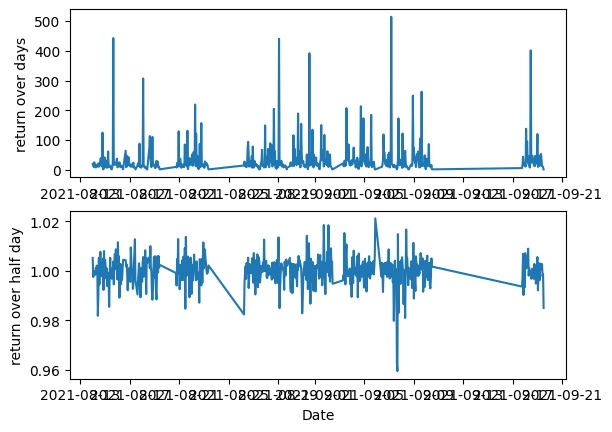

In [72]:
fig, axis = plt.subplots(2)

plt.xlabel('Date')
axis[0].plot(merged_df['timestamp'],merged_df['score'])
axis[0].set_ylabel("return over days")
axis[1].plot(merged_df['timestamp'],merged_df['return'])
axis[1].set_ylabel("return over half day")

In [73]:
trace1 = go.Scatter(x=merged_df['timestamp'], y=merged_df['score'], mode='lines', name='Return over days')
trace2 = go.Scatter(x=merged_df['timestamp'], y=merged_df['return'], mode='lines', name='Return over half day')

# Create subplot layout
fig = go.Figure()

# Add traces to subplot 1
fig.add_trace(trace1)

# Create and add subplot 2
fig.add_trace(trace2)

# Update layout
fig.update_layout(
    title='Return Analysis',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Return over days', side='left', showgrid=False),
    yaxis2=dict(title='Return over half day', overlaying='y', side='right', showgrid=False),
    legend=dict(
        x=0.01,
        y=0.99,
        bgcolor='rgba(0,0,0,0)'
    )
)

# Show the plot
fig.show()

In [74]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [75]:
scaler = MinMaxScaler()
merged_df['return_scaled_normalized'] = scaler.fit_transform(merged_df[['return']])

In [76]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=merged_df['score'], y=merged_df['return_scaled_normalized'], 
                         mode='markers', 
                         marker=dict(color='rgba(50, 150, 250, 0.7)'), 
                         name='Scaled and Normalized Return'))

fig.update_layout(title='Scatter Plot of Scaled and Normalized Return vs Score',
                  xaxis_title='Score',
                  yaxis_title='Scaled and Normalized Return',
                  template='plotly_dark')

fig.show()

In [77]:
def correlation_gauge(merged_df):
    # Calculate Pearson correlation coefficient and p-value
    pearson_corr, _ = pearsonr(merged_df['return'], merged_df['score'])

    # Calculate Spearman correlation coefficient and p-value
    spearman_corr, _ = spearmanr(merged_df['return'], merged_df['score'])

    # Create gauge plot
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode="gauge+number",
        value=pearson_corr,
        domain={'x': [0, 0.5], 'y': [0, 1]},
        title={'text': "Pearson Correlation"},
        gauge={'axis': {'range': [-1, 1]}}  # Range for Pearson correlation
    ))

    fig.add_trace(go.Indicator(
        mode="gauge+number",
        value=spearman_corr,
        domain={'x': [0.5, 1], 'y': [0, 1]},
        title={'text': "Spearman Correlation"},
        gauge={'axis': {'range': [-1, 1]}}  # Range for Spearman correlation
    ))

    # Update layout
    fig.update_layout(template='plotly_dark', width=800, height=300)

    # Show plot
    fig.show()

In [78]:
correlation_gauge(merged_df)

In [79]:
merged_df.to_csv('btc_reddit.csv',index= False)

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [81]:
X = merged_df[['score']]  # Feature: Reddit score
y = merged_df[['return_scaled_normalized']]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [84]:
y_pred = model.predict(X_test)

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [86]:
print('Intercept:', model.intercept_[0])
print('Coefficient:', model.coef_[0][0])

# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Calculate evaluation metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print evaluation metrics
print('Training Set:')
print('Mean Squared Error (MSE):', mse_train)
print('Mean Absolute Error (MAE):', mae_train)
print('R-squared (R2):', r2_train)

print('\nTest Set:')
print('Mean Squared Error (MSE):', mse_test)
print('Mean Absolute Error (MAE):', mae_test)
print('R-squared (R2):', r2_test)

Intercept: 0.6513902262297159
Coefficient: 4.1723039290201e-05
Training Set:
Mean Squared Error (MSE): 0.009167709669489193
Mean Absolute Error (MAE): 0.06516216122190494
R-squared (R2): 0.0005558902539238852

Test Set:
Mean Squared Error (MSE): 0.009259222001929267
Mean Absolute Error (MAE): 0.07184559205874161
R-squared (R2): -0.012804009533182725


In [87]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [88]:
train_size = int(len(merged_df) * 0.8)
train_data, test_data = merged_df[:train_size], merged_df[train_size:]

In [90]:
model = ExponentialSmoothing(train_data['return'], trend='add', seasonal='add', seasonal_periods=24).fit()

In [91]:
forecast = model.forecast(steps=len(test_data))

In [93]:
y_pred = forecast

In [94]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2):', r2)

Mean Squared Error (MSE): 0.12201302355958804
Mean Absolute Error (MAE): 0.33593572806781213
R-squared (R2): -12.346183885716218


In [95]:
# Plot the actual data and forecasted values
fig = go.Figure()

# Add actual data
fig.add_trace(go.Scatter(x=train_data['timestamp'], y=train_data['return'], mode='lines', name='Actual'))

# Add forecasted values
fig.add_trace(go.Scatter(x=test_data['timestamp'], y=y_pred, mode='lines', name='Forecast'))

# Update layout with dark theme
fig.update_layout(title='Cryptocurrency Return Forecast',
                  xaxis_title='Timestamp',
                  yaxis_title='Return',
                  template='plotly_dark')  # Set dark theme

# Show plot
fig.show()

In [96]:
from tabulate import tabulate

# Linear regression metrics
lr_metrics = {
    'Model': 'Linear Regression',
    'Mean Squared Error (MSE)': mse_test,
    'Mean Absolute Error (MAE)': mae_test,
    'R-squared (R2)': r2_test
}

# Exponential smoothing metrics
es_metrics = {
    'Model': 'Exponential Smoothing',
    'Mean Squared Error (MSE)': mse,
    'Mean Absolute Error (MAE)': mae,
    'R-squared (R2)': r2
}

# Create a list of metrics dictionaries
metrics_list = [lr_metrics, es_metrics]

# Print the table
print(tabulate(metrics_list, headers='keys', tablefmt='pretty'))

+-----------------------+--------------------------+---------------------------+-----------------------+
|         Model         | Mean Squared Error (MSE) | Mean Absolute Error (MAE) |    R-squared (R2)     |
+-----------------------+--------------------------+---------------------------+-----------------------+
|   Linear Regression   |   0.009259222001929267   |    0.07184559205874161    | -0.012804009533182725 |
| Exponential Smoothing |   0.12201302355958804    |    0.33593572806781213    |  -12.346183885716218  |
+-----------------------+--------------------------+---------------------------+-----------------------+
